In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
TARGET_NAME = 'choose'

In [3]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
0,0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0
1,1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,1
2,2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,0
3,3,33.0,3.0,1050.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,1
4,4,46.0,3.0,2250.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,73.0,0


Обработка пропусков

In [4]:
len(df_train) - df_train.count()

Id                     0
age                    0
years_of_experience    0
lesson_price           0
qualification          0
physics                0
chemistry              0
biology                0
english                0
geography              0
history                0
mean_exam_points       0
choose                 0
dtype: int64

Обработка выбросов

In [5]:
df_train.loc[df_train['age'] > 70]

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose


In [6]:
df_train.loc[df_train['age'] < 20]

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose


In [7]:
df_train.loc[df_train['lesson_price'] < 200]

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose


In [8]:
df_train.loc[df_train['years_of_experience'] > 9]

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose


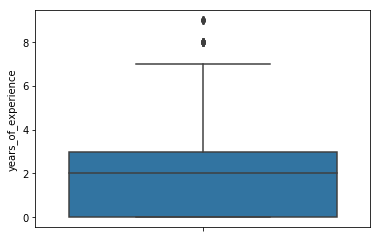

In [9]:
sns.boxplot(y="years_of_experience", data=df_train)

In [10]:
df_train.loc[df_train['qualification'] > 4]

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose


In [11]:
df_train.loc[df_train['mean_exam_points'] >= 100]

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
5180,5180,51.0,5.0,2450.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,100.0,0


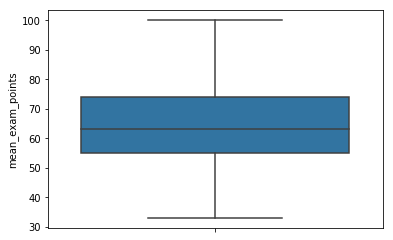

In [12]:
sns.boxplot(y="mean_exam_points", data=df_train)

Отбор только значимых параметров

Корреляция с базовыми признаками

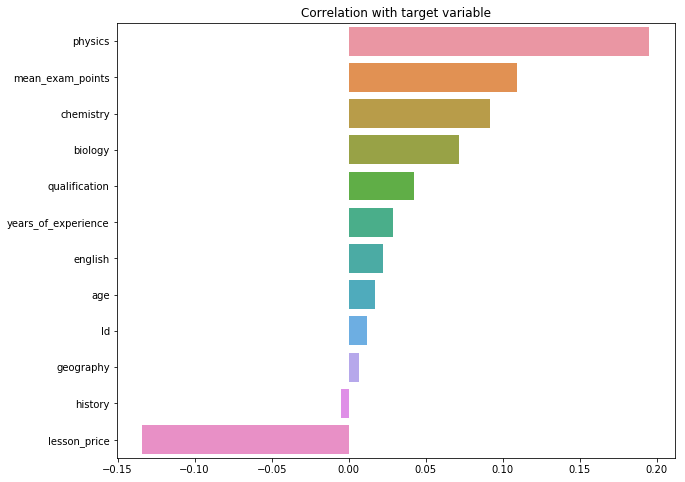

In [13]:
corr_with_target = df_train.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [14]:
FEATURE_NAMES_SELECTED = ['years_of_experience','lesson_price','qualification','physics','chemistry','biology','mean_exam_points','english']

In [15]:
sum(df_train['choose']==1)

1109

In [16]:
sum(df_train['choose']==0)

8891

### Балансировка целевой переменной<a class="anchor" id="target_balancing"></a>

In [17]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [18]:
def get_recall(pred, y):
    y_filtered = y[y == pred] 
    return sum(y_filtered) / sum(y)

In [19]:
def get_presicion(pred, y):
    y_filtered = y[y == pred]
    return sum(y_filtered) / sum(pred)

In [20]:
def get_error(pred, y):
    return sum(pred != y) / len(y)

RANDOMFOREST

In [21]:
import random

In [22]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    print(n_samples)
    print(len(data))
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
#            print(data[sample_index])
            b_data[j] = data.iloc[sample_index]
            b_labels[j] = labels.iloc[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [23]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [24]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [25]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [26]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [27]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [28]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [29]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [30]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [31]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [32]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [33]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    
    for i in range(len(data)):
        prediction = classify_object(data.iloc[i], tree)
        classes.append(prediction)
    return classes

In [34]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [35]:
# Разобьем выборку на обучающую и тестовую

#from sklearn import model_selection

#train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
#                                                                                     classification_labels, 
#                                                                                     test_size = 0.3,
#                                                                                     random_state = 1)

X = df_train[FEATURE_NAMES_SELECTED]
y = df_train[TARGET_NAME]

train_data, test_data, train_labels, test_labels = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)
train_data.iloc[0]

years_of_experience       4.0
lesson_price           2950.0
qualification             3.0
physics                   0.0
chemistry                 0.0
biology                   1.0
mean_exam_points         92.0
english                   0.0
Name: 2886, dtype: float64

In [36]:
df_for_balancing = pd.concat([train_data, train_labels], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  


0    6669
1    6648
Name: choose, dtype: int64

In [37]:
train_data = df_balanced.drop(columns=TARGET_NAME)
train_labels = df_balanced[TARGET_NAME]

In [38]:
print(len(train_data))

13317


In [39]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual.iloc[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [40]:
n_trees = 20
my_forest_10 = random_forest(train_data, train_labels, n_trees)

13317
13317


In [41]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_10, train_data)

In [42]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_10, test_data)

In [43]:
# Точность на обучающей выборке
print(type(train_labels))
print(type(train_answers))
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

<class 'pandas.core.series.Series'>
<class 'list'>
Точность случайного леса из 20 деревьев на обучающей выборке: 82.609


In [44]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 20 деревьев на тестовой выборке: 75.480


In [45]:
def get_recall(pred, y):
    y_filtered = y[y == pred] 
    return sum(y_filtered) / sum(y)

def get_presicion(pred, y):
    y_filtered = y[y == pred]
    return sum(y_filtered) / sum(pred)

def get_error(pred, y):
    return sum(pred != y) / len(y)

In [46]:
get_recall(train_answers, train_labels)

0.8739470517448856

In [47]:
get_presicion(train_answers, train_labels)

0.7972008781558727

In [48]:
get_error(train_answers, train_labels)

0.17391304347826086

In [49]:
recall = get_recall(test_answers, test_labels)
print('recall: ',recall)

presicion = get_presicion(test_answers, test_labels)
print('presicion: ',get_presicion(test_answers, test_labels))

error = get_error(test_answers, test_labels)
print('error:', error)

recall:  0.6618705035971223
presicion:  0.26173541963015645
error: 0.2452


In [50]:
f1_score = recall * presicion / (presicion + recall)

In [51]:
print(f1_score)

0.1875637104994903


In [56]:
# расчет вероятности

def tree_probability(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве вероятности для каждого объекта то,
    # среднюю величину по каждому объекту
    probability_predictions = []
    for obj in predictions_per_object:
        probability_predictions.append(sum(obj)/len(obj))
        
    return probability_predictions

In [57]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,10000,32.0,2.0,2700.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0
1,10001,35.0,6.0,1800.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,71.0
2,10002,44.0,2.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0
3,10003,44.0,4.0,2950.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,92.0
4,10004,38.0,3.0,1400.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,58.0


In [58]:
FEATURE_NAMES_SELECTED.append('Id') 
test_data = df_test[FEATURE_NAMES_SELECTED]

In [59]:
# И получим ответы для тестовой выборки
test_answers = tree_probability(my_forest_10, test_data)
df_test[TARGET_NAME] = test_answers 

In [62]:
RESULT_FIELDS = ['Id']
RESULT_FIELDS.append(TARGET_NAME)
df_test.loc[:,RESULT_FIELDS].to_csv('VZinchenko_predictions.csv',index=None)